# Building Agents

> 这一部分内容，我们将使用 LangGraph 构建第一个 AI Agent，如果你还不熟悉 LangGraph 和 Agent 是什么，请务必先熟悉之前的内容。

我们要构建的 Agent 是一个邮件助手，可以帮助我们自动回复邮件，在需要的时候，会寻求人类的意见。邮件助手的架构图如下：

![overview-img](img/overview.png)

图中有以下几个部分：
- **Agent(LangGraph)**： 本节要实现的内容，一个能自动分类邮件并进行回复的 agent，是我们要构建的整个 Agent 的一部分；
- **Interrupt -> Human Feedback**：通过中断功能实现人类反馈，后续的章节会详细介绍；
- **Memory(Updating)**：记忆功能，后续的章节会详细介绍；
- **E-mail Response Draft & E-mail Service**：工具调用的模块。

本章节将完成 **Agent(LangGraph)** 模块的内容。该模块分为两个部分：
1. 路由模块（Router）负责分析邮件应该如何处理；
2. 邮件回复模块（Response Agent）负责根据邮件分类的结果，回复邮件。

## 加载环境变量

In [3]:
from dotenv import load_dotenv
load_dotenv("../.env")
import os
import sys
sys.path.append("..")

model_name = os.getenv("OPENAI_MODEL")
model_provider = os.getenv("MODEL_PROVIDER")

## 定义工具（Tools）

首先，我们要确定我们能使用的工具有哪些，将这些工具通过 `@tool` 装饰器来定义。

In [4]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel
from langchain_core.tools import tool

我们将定义4个工具，分别是：

1. `write_email`：撰写并发送邮件
2. `schedule_meeting`：制定会议日程
3. `check_calendar_availability`：获取某一天的空闲时间
4. `Done`：结束当前任务

In [37]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool

仔细观察可以发现， `Done` 工具的作用是用于标记任务已经完成，并且它是通过 `pydantic.BaseModel` 来实现的，而不是通过普通函数。

`BaseModel` 可以作为工具函数的原因是 LangChain 的 `@tool` 装饰器被设计为多态的，它能够智能地处理不同类型的输入（函数或类），并将它们统一转换为符合工具接口的对象。

## 构建邮件助手

前面已经提到，我们要构建的初始版本的邮件助手包含两部分内容，一个 router 和一个 response_agent，这里的agent就是我们在01节介绍的agent，如下图右边所示，**agent就是一个不断通过调用工具与外部交互并获得反馈再进行决策的循环**。

> 有很多人会觉得疑惑，我们不是要构建会自动处理邮件的 AI agent 吗，为什么这里已经包含一个agent了？这俩agent是一个意思吗？
> 其实大家不用纠结agent这个概念，agent 就是一个能自主决策的工具，一个agent中可能包含另一个agent，把这个子agent当成一个工具来用。

![agent_workflow_img](img/email_workflow.png)



### 路由（Router）

Router 的作用是根据输入内容判断，决定下一步该调用哪个模块来处理。需要注意的是，Router 模块只负责做这一件事，这也是一个非常好的设计习惯。

#### State

当我们使用 LangGraph 构建 agent 时，首先，需要明确哪些信息需要被记录下来，我们将使用 LangGraph 的预构建[`MessagesState` 对象](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)，它只是一个带有 `messages` 字段的字典，该对象将节点返回的信息追加到`messages`列表中[作为其更新逻辑](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)。为了追踪我们需要的其它信息，我们将创建一个自定义的 `State` 对象，继承自 `MessagesState`。



In [6]:
from langgraph.graph import MessagesState

class State(MessagesState):
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

`State` 类中，我们添加了两个新的字段：
- `email_input`: 用于存储输入的邮件信息
- `classification_decision`: 用于存储 Router 的决策结果

但是，不要忘记，`State` 类是继承自 `MessagesState` 的，所以它仍然保留了 `messages` 字段，用于存储对话历史。

### 分类节点（Triage node）

我们会定义一个函数来实现这个功能。为了实现这个函数，我们将借助 Pydantic Model 来实现结构化输出（[structured outputs](https://python.langchain.com/docs/concepts/structured_outputs/)）。

Pydantic Model 可以帮我们定义好数据的 schemas，并且提供类型提示和验证的功能。Pydantic Model 中的描述也很重要，因为这部分描述会被输入到大语言模型，用于让大模型做强制类型转换。

In [7]:
from pydantic import BaseModel, Field
from src.utils import parse_email, format_email_markdown
from src.prompts import triage_system_prompt, triage_user_prompt, default_triage_instructions, default_background
from langchain.chat_models import init_chat_model
from langgraph.graph import END
from langgraph.types import Command

from IPython.display import Markdown

我们通过 `Markdown` 来看一下这些提示词。

In [47]:
# 分类节点系统提示词
Markdown(triage_system_prompt)



< Role >
Your role is to triage incoming emails based upon instructs and background information below.
</ Role >

< Background >
{background}. 
</ Background >

< Instructions >
Categorize each email into one of three categories:
1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that worth notification but doesn't require a response
3. RESPOND - Emails that need a direct response
Classify the below email into one of these categories.
</ Instructions >

< Rules >
{triage_instructions}
</ Rules >


In [48]:
# 分类节点用户提示词
Markdown(triage_system_prompt)




< Role >
Your role is to triage incoming emails based upon instructs and background information below.
</ Role >

< Background >
{background}. 
</ Background >

< Instructions >
Categorize each email into one of three categories:
1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that worth notification but doesn't require a response
3. RESPOND - Emails that need a direct response
Classify the below email into one of these categories.
</ Instructions >

< Rules >
{triage_instructions}
</ Rules >


In [49]:
# 默认的背景信息
Markdown(default_background)

 
I'm Lance, a software engineer at LangChain.


In [50]:
# 默认的分类指示指令
Markdown(default_triage_instructions)


Emails that are not worth responding to:
- Marketing newsletters and promotional emails
- Spam or suspicious emails
- CC'd on FYI threads with no direct questions

There are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:
- Team member out sick or on vacation
- Build system notifications or deployments
- Project status updates without action items
- Important company announcements
- FYI emails that contain relevant information for current projects
- HR Department deadline reminders
- Subscription status / renewal reminders
- GitHub notifications

Emails that are worth responding to:
- Direct questions from team members requiring expertise
- Meeting requests requiring confirmation
- Critical bug reports related to team's projects
- Requests from management requiring acknowledgment
- Client inquiries about project status or features
- Technical questions about documentation, code, or APIs (especially questions about missing endpoints or features)
- Personal reminders related to family (wife / daughter)
- Personal reminder related to self-care (doctor appointments, etc)


我们定义了一个类 `RouterSchema` 来格式化大模型的输出，其中包含两个字段：
- `reasoning`：分类邮件的推理过程
- `classification`：邮件分类结果

在实际处理的过程中，LangChain 会将这个类转换成一串 Prompt 发给大语言模型，这个提示词大概长这样：
```
You are to return a JSON object that matches the following schema:
{
  "reasoning": "string",
  "classification": "integer"
}
```

In [8]:
class RouterSchema(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )


接下来，初始化 llm，并通过 `with_structured_output` 方法，来指定 llm 的输出格式。

> **注意** `with_structured_output` 方法对 `qwen` 相关的模型并不支持，建议使用`openai` 的模型。如果实际项目中使用 qwen 的模型，可以添加一些方法来实现相同的功能。
> 1. 将 `RouterSchema` 转成 prompt
> 2. 将 llm 的输出转成 `RouterSchema` 的格式

In [9]:
llm = init_chat_model(model_name, model_provider=model_provider, temperature=0)
llm_router = llm.with_structured_output(RouterSchema)

现在定义邮件分类节点，这个节点做的事，就是根据邮件内容，决定如何回复： respond, notify, or ignore

代码中有几点说明一下：
- 函数输出结果类型中的 `__end__` 实际上和 `END` 表示的内容一致，这里不用 `END` 是因为它是一个常量，这里不支持；
- 使用了 `match-case` 语句代替了常用的 `if-else` 语句，这是 python 3.10 引入的新特性；
- 函数返回的 `Command` 命令有两个作用，一是更新 state 信息，而是跳转到下一个节点。

In [25]:
def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""

    # 从输入的邮件信息中提取对应的字段
    author, to, subject, email_thread = parse_email(state["email_input"])
    
    # 格式化完整的 system prompt
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions,
    )

    # 格式化完整的 user prompt
    user_prompt = triage_user_prompt.format(
        author=author,
        to=to,
        subject=subject,
        email_thread=email_thread,
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    print("=== result of llm_router ===")
    print(f"type: {type(result)}")
    print(f"resoning: {result.reasoning}")
    print(f"classification: {result.classification}", end='\n')

    match result.classification:
        case "respond":
            print("📧 Classification: RESPOND - This email requires a response")
            goto = "response_agent"
            # 如果邮件需要回复，我们会在聊天记录中添加一条用户消息，用于提示 llm 回复邮件
            update = {
                "messages": [
                    {
                        "role": "user",
                        "content": f"Respond to the email: \n\n{format_email_markdown(subject, author, to, email_thread)}",
                    }
                ],
                "classification_decision": result.classification,
            }
        case "ignore":
            print("🚫 Classification: IGNORE - This email can be safely ignored")
            goto = END
            update = {
                "classification_decision": result.classification,
            }
        case "notify":
            print("🔔 Classification: NOTIFY - This email contains important information")
            # For now, we go to END. But we will add to this later!
            goto = END
            update = {
                "classification_decision": result.classification,
            }
        case _:
            raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

测试一下效果，主要关注一下 `llm_router` 输出的内容，以及整个函数的返回结果。

In [14]:
triage_router({"email_input": {"author": "张三", "to": "李四", "subject": "项目进展", "email_thread": "我们正在按照计划推进项目，预计下周完成。"}})

=== result of llm_router === 

type: <class '__main__.RouterSchema'>
resoning: The email provides an update on project progress, stating that it is on schedule and expected to be completed next week. This is important information for awareness but does not require a response.
classification: notify
🔔 Classification: NOTIFY - This email contains important information


Command(update={'classification_decision': 'notify'}, goto='__end__')

### Response Agent

上面这部分代码构建好了分类 router，接下来，我们开始构建第二部分 response_agent。

#### LLM Node

首先，我们需要一个大模型节点充当“大脑”，用于决策。这个节点根据当前state内容，调用大模型，生成后续的内容。


In [11]:
from src.tools.default.prompt_templates import AGENT_TOOLS_PROMPT
from src.prompts import agent_system_prompt, default_response_preferences, default_cal_preferences

In [16]:
Markdown(AGENT_TOOLS_PROMPT)


1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings where preferred_day is a datetime object
3. check_calendar_availability(day) - Check available time slots for a given day
4. Done - E-mail has been sent


In [17]:
Markdown(agent_system_prompt)


< Role >
You are a top-notch executive assistant who cares about helping your executive perform as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage communications and schedule:
{tools_prompt}
</ Tools >

< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. For responding to the email, draft a response email with the write_email tool
4. For meeting requests, use the check_calendar_availability tool to find open time slots
5. To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter
   - Today's date is 2025-05-31 - use this for scheduling meetings accurately
6. If you scheduled a meeting, then draft a short response email using the write_email tool
7. After using the write_email tool, the task is complete
8. If you have sent the email, then use the Done tool to indicate that the task is complete
</ Instructions >

< Background >
{background}
</ Background >

< Response Preferences >
{response_preferences}
</ Response Preferences >

< Calendar Preferences >
{cal_preferences}
</ Calendar Preferences >


In [12]:
full_agent_system_prompt = agent_system_prompt.format(
                        tools_prompt=AGENT_TOOLS_PROMPT,
                        background=default_background,
                        response_preferences=default_response_preferences,
                        cal_preferences=default_cal_preferences, 
                    )
Markdown(full_agent_system_prompt)


< Role >
You are a top-notch executive assistant who cares about helping your executive perform as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings where preferred_day is a datetime object
3. check_calendar_availability(day) - Check available time slots for a given day
4. Done - E-mail has been sent

</ Tools >

< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. For responding to the email, draft a response email with the write_email tool
4. For meeting requests, use the check_calendar_availability tool to find open time slots
5. To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter
   - Today's date is 2025-05-31 - use this for scheduling meetings accurately
6. If you scheduled a meeting, then draft a short response email using the write_email tool
7. After using the write_email tool, the task is complete
8. If you have sent the email, then use the Done tool to indicate that the task is complete
</ Instructions >

< Background >
 
I'm Lance, a software engineer at LangChain.

</ Background >

< Response Preferences >

Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.

When responding to technical questions that require investigation:
- Clearly state whether you will investigate or who you will ask
- Provide an estimated timeline for when you'll have more information or complete the task

When responding to event or conference invitations:
- Always acknowledge any mentioned deadlines (particularly registration deadlines)
- If workshops or specific topics are mentioned, ask for more specific details about them
- If discounts (group or early bird) are mentioned, explicitly request information about them
- Don't commit 

When responding to collaboration or project-related requests:
- Acknowledge any existing work or materials mentioned (drafts, slides, documents, etc.)
- Explicitly mention reviewing these materials before or during the meeting
- When scheduling meetings, clearly state the specific day, date, and time proposed

When responding to meeting scheduling requests:
- If times are proposed, verify calendar availability for all time slots mentioned in the original email and then commit to one of the proposed times based on your availability by scheduling the meeting. Or, say you can't make it at the time proposed.
- If no times are proposed, then check your calendar for availability and propose multiple time options when available instead of selecting just one.
- Mention the meeting duration in your response to confirm you've noted it correctly.
- Reference the meeting's purpose in your response.

</ Response Preferences >

< Calendar Preferences >

30 minute meetings are preferred, but 15 minute meetings are also acceptable.

</ Calendar Preferences >


In [35]:
# collect the tools
tools = [write_email, schedule_meeting, check_calendar_availability, Done]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize the llm and enforce tool use
llm = init_chat_model(model_name, model_provider=model_provider, temperature=0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any", parallel_tool_calls=False)


def llm_call(state: State):
    """LLM decides whether call a tool or not"""

    # Invoke the LLM
    output = llm_with_tools.invoke(
                # Add the system prompt
                [   
                    {"role": "system", "content": full_agent_system_prompt},
                ]
                # Add the current messages to the prompt
                + state["messages"]
            )

    return {"messages": [output]}

#### 工具调用节点

LLM 节点做出决策使用哪个工具后，需要一个 `tool_handler` 节点来调用工具。该节点调用工具，并将调用工具的结果更新到 state 中。

In [ ]:
def tool_handler(state: State):
    """Perform the tool call."""

    # list for tool results
    result = []

    # iterate excute tool call
    for tool_call in state["messages"][-1].tool_calls:
        tool_name = tool_call["name"]
        tool = tools_by_name[tool_name]
        observation = tool.invoke(tool_call["args"])
        result.append({
            "role": "tool",
            "content": observation,
            "tool_call_id": tool_call["id"]
        })

    return {"messages": result}

#### Conditional Routing

条件路由节点帮助 agent 选择的功能，什么时候调用工具，什么时候结束任务。

In [30]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called"""

    # get the last message
    messages = state["messages"]
    last_message = messages[-1]

    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

#### Agent Graph

最后，我们把上述的所有组件都整合到一起，构建一个完整的 Agent Graph。

In [18]:
from langgraph.graph import StateGraph, START, END
from src.utils import show_graph

In [31]:
# build workflow
overall_workflow = StateGraph(State)

# add node
overall_workflow.add_node('llm_call', llm_call)
overall_workflow.add_node('tool_handler', tool_handler)

# add edge
overall_workflow.add_edge(START, 'llm_call')
overall_workflow.add_conditional_edges(
    'llm_call',
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END
    }
)
overall_workflow.add_edge('tool_handler', 'llm_call')

# compile
agent = overall_workflow.compile()

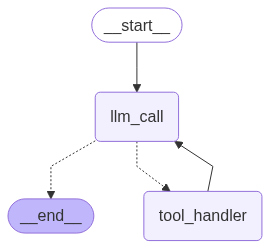

In [20]:
show_graph(agent)

我们构建了一个 graph：
1. 从 llm decision 开始
2. 选择结束任务或者调用工具
3. 调用工具的结果反馈给 llm decision 用于下次决策
4. 重复执行直到任务完成或者达到最大工具调用次数

### 组合 Router 和 Response Agent

接下来，将第一部分设计的 Router 与第二部分设计的 Agent 进行组合，得到一个完整的智能体。

In [32]:
overall_workflow = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node('response_agent', agent)
    .add_edge(START, "triage_router")
).compile()

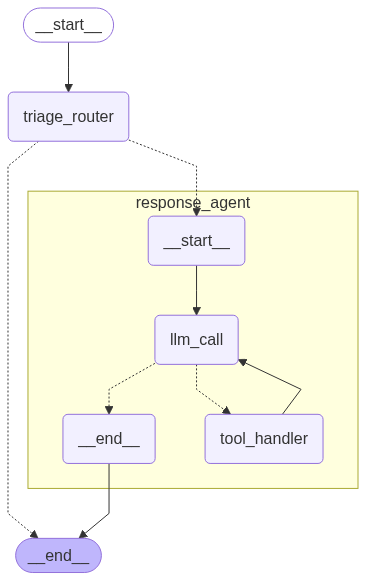

In [24]:
show_graph(overall_workflow, xray=True)

`show_graph` 函数中我们通过添加 `xray=True` 参数，将子 agent 也展开显示了出来。通过这个图可以看出， agent 作为选项的一部分添加到了 triage_router 后，triage_router 是通过 `Command` 中的 goto 参数来决定去向的。
- 如果邮件需要回复，则 goto `response_agent`，即 agent
- 如果邮件不需要回复，则 goto `END`

整体上看，整个流程如下：
1. `triage_router` 分析邮件输入
2. 如果有必要，`response_agent` 起草一份邮件
3. 当 `triage_router` 决定邮件不需要回复时，或者 `response_agent` 已经完成任务时，流程结束

## 测试

### 测试用例

第一个示例是一个通知邮件，不需要回复，直接从 triage_router 跳转到 END 节点。

In [27]:
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": "Hi team,\n\nThis is a reminder that we'll be performing scheduled maintenance on the production database tonight from 2AM to 4AM EST. During this time, all database services will be unavailable.\n\nPlease plan your work accordingly and ensure no critical deployments are scheduled during this window.\n\nThanks,\nSystem Admin Team"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

=== result of llm_router ===
type: <class '__main__.RouterSchema'>
resoning: The email is providing important information about scheduled maintenance on the production database that will affect service availability. It does not require a response, but team members need to be informed so they can plan their work accordingly.
classification: notify
🔔 Classification: NOTIFY - This email contains important information


第二个例子是一个需要回复的邮件。

In [ ]:
email_input = {
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}

# Run the agent
response = overall_workflow.invoke({"email_input": email_input})
for m in response["messages"]:
    m.pretty_print()

### langgraph cli 部署测试

通过 langgraph cli 可以方便的本地进行部署和测试。

首先，我们将所有的代码整理到 `../src/email_assistant.py` 文件中，然后在 `../langgraph.json` 中指定该文件作为入口，该文件是 langgraph cli 的配置文件。

最后，执行 `langgraph cli` 的命令行命令，即可启动本地服务。

```sh
cd ../
langgraph dev
```

![langgraph_dev_demo.png](./img/langgraph_dev_demo.png)

如上图所示，服务启动后，在UI页面的左边输入框输入测试邮件内容
```json
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}
```

点击提交后，稍等片刻即可在右侧看到执行的过程和结果。